In [1]:
import asyncio
import lsst_efd_client

import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import pytz
import sys
from astropy.stats import median_absolute_deviation as mad_astropy
from scipy.stats import binned_statistic
from astropy.time import Time
from tqdm import tqdm

from lsst.summit.utils import (
    ConsDbClient,
    getAirmassSeeingCorrection,
    getBandpassSeeingCorrection,
)
from lsst.summit.utils.efdUtils import makeEfdClient
import os
import pickle

%matplotlib inline

In [2]:
os.environ["no_proxy"] += ",.consdb"
consdb_url = 'http://consdb-pq.consdb:8080/consdb'
cdb_client = ConsDbClient(consdb_url)

efd_client = makeEfdClient()

In [3]:
query = f"""
SELECT
e.exposure_id AS visit_id,
e.band, 
e.day_obs AS day_obs,
e.obs_start_mjd,
e.obs_end_mjd,
e.exp_midpt AS time,
e.dimm_seeing AS seeing,
e.focus_z AS focus_z, 
e.science_program AS science_program,
e.wind_speed AS wind_speed,
e.wind_dir AS wind_dir,
ccdvisit1_quicklook.psf_sigma,
ccdvisit1_quicklook.z4,
ccdvisit1_quicklook.z5,
ccdvisit1_quicklook.z6,
ccdvisit1_quicklook.z7,
ccdvisit1_quicklook.z8,
ccdvisit1_quicklook.z9,
ccdvisit1_quicklook.z10,
ccdvisit1_quicklook.z11,
ccdvisit1_quicklook.z12,
ccdvisit1_quicklook.z13,
ccdvisit1_quicklook.z14,
ccdvisit1_quicklook.z15,
ccdvisit1_quicklook.z16,
ccdvisit1_quicklook.z17,
ccdvisit1_quicklook.z18,
ccdvisit1_quicklook.z19,
ccdvisit1_quicklook.z20,
ccdvisit1_quicklook.z21,
ccdvisit1_quicklook.z22,
ccdvisit1_quicklook.z23,
ccdvisit1_quicklook.z24,
ccdvisit1_quicklook.z25,
ccdvisit1_quicklook.z26,
ccdvisit1_quicklook.z27,
ccdvisit1_quicklook.z28,
ccdvisit1.detector as detector,
q.donut_blur_fwhm AS donut_blur,
q.ringss_seeing AS ringss_seeing,
q.psf_sigma_median AS psf_fwhm,
q.psf_sigma_min AS psf_fwhm_min,
q.psf_sigma_max AS psf_fwhm_max,
q.physical_rotator_angle,
e.obs_end,
e.obs_start,
e.seq_num
FROM
cdb_lsstcam.ccdvisit1_quicklook AS ccdvisit1_quicklook,
cdb_lsstcam.ccdvisit1 AS ccdvisit1,
cdb_lsstcam.visit1 AS visit1,
cdb_lsstcam.visit1_quicklook AS q,
cdb_lsstcam.exposure AS e
WHERE
ccdvisit1.detector IN (191, 192, 195, 196, 199, 200, 203, 204)
AND ccdvisit1.ccdvisit_id = ccdvisit1_quicklook.ccdvisit_id
AND ccdvisit1.visit_id = visit1.visit_id
AND ccdvisit1.visit_id = q.visit_id
AND ccdvisit1.visit_id = e.exposure_id
AND (e.img_type = 'science')
AND e.airmass > 0
AND e.band != 'none'
"""

table = cdb_client.query(query).to_pandas()

In [13]:
zernike4 = {}

for i in range(len(table)):
    if int(table['visit_id'][i]) not in zernike4:
        zernike4.update({int(table['visit_id'][i]): {
            #"z4": [float(table['z4'][i])], 
            "visit_id": table['visit_id'][i],
            "band": table['band'][i],
            "obs_start_mjd": table['obs_start_mjd'][i],
            "obs_end_mjd": table["obs_end_mjd"][i],
        }})
        for j in range(28-4):
            zcoeff = table['z%i'%(j+4)][i]
            if zcoeff is None:
                zcoeff = np.nan
            else:
                zcoeff = float(zcoeff)
            zernike4[int(table['visit_id'][i])].update({"z%i"%(j+4): [zcoeff],})
            
    else:
        for j in range(28-4):
            zcoeff = table['z%i'%(j+4)][i]
            if zcoeff is None:
                zcoeff = np.nan
            else:
                zcoeff = float(zcoeff)
            zernike4[int(table['visit_id'][i])]["z%i"%(j+4)].append(zcoeff)

visitIDs = [visit for visit in zernike4]
visitIDs.sort()

#band = np.array([zernike4[visit]["band"] for visit in visitIDs])
#obs_start_mjd = np.array([zernike4[visit]["obs_start_mjd"] for visit in visitIDs])
#obs_end_mjd = np.array([zernike4[visit]["obs_end_mjd"] for visit in visitIDs])
#z4 = np.array([np.median(zernike4[visit]["z4"]) for visit in visitIDs])

filePkl = open('visit_to_band_mapv2.pkl', 'wb')
pickle.dump(zernike4, filePkl)
filePkl.close()

In [ ]:
deltaz4 = {}

for i in tqdm(range(len(visitIDs)-1)):
    process = True
    if str(visitIDs[i])[:8] != str(visitIDs[i+1])[:8]:
        process &= False
    if obs_start_mjd[i+1] - obs_end_mjd[i] > (((1. / 24.) / 60.) * 5.): #5 minutes
        process &= False
    key = str(band[i]) + '_' + str(band[i+1])
    if band[i] !=  band[i+1]:
        key_to_filter = str(band[i]) + '_' + "filters"
        filter_to_key = "filters" + '_' + str(band[i+1])
    else: 
        key_to_filter = None
        filter_to_key = None
    
    if process:

        if key not in deltaz4:
            deltaz4.update({key: [z4[i+1]-z4[i]]})
        else:
            deltaz4[key].append(z4[i+1]-z4[i])

        if key_to_filter is not None:
            if key_to_filter not in deltaz4:
                deltaz4.update({key_to_filter: [z4[i+1]-z4[i]]})
            else:
                deltaz4[key_to_filter].append(z4[i+1]-z4[i])

            if filter_to_key not in deltaz4:
                deltaz4.update({filter_to_key: [z4[i+1]-z4[i]]})
            else:
                deltaz4[filter_to_key].append(z4[i+1]-z4[i])

            
            

In [ ]:
# key --> key 

#np.random.seed(42)
#data = np.random.uniform(-3, 3, (1, 6))
BAND = ['u', 'g', 'r', 'i', 'z', 'y']
z_score = np.zeros((1, 6))
dz4 = np.zeros((1, 6))
dz4_error = np.zeros((1, 6))
N_exchange = np.zeros((1, 6))

for i in range((len(BAND))):
    key = f"{BAND[i]}_{BAND[i]}"
    dz4[0, i] = np.nanmean(deltaz4[key])
    dz4_error[0, i] = np.nanstd(deltaz4[key]) / np.sqrt(len(deltaz4[key]))
    z_score[0, i] = dz4[0, i] / dz4_error[0, i]
    N_exchange[0, i] = len(deltaz4[key])


# 2. Define discrete boundaries for the color scale
# Values between -1 and 1 will be white.
# -2 to -1 will be light blue, 1 to 2 will be light red, etc.
bounds = [-5, -4, -3, -2, 2, 3, 4, 5]
cmap = plt.cm.seismic
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# 3. Set up the plot
fig, ax = plt.subplots(figsize=(10, 2.5))

# Use aspect='auto' to make the row height look like a table
im = ax.imshow(z_score, cmap=cmap, norm=norm, aspect='auto')

# 4. Display the value for each element
for j in range(6):
    val = z_score[0, j]
    # Change text color to white if the background is dark (high z-scores)
    text_color = "white" if abs(val) > 2 else "black"
    
    ax.text(j, 0, f'{dz4[0, j]:.3f}$\\mu$m \n {z_score[0, j]:.2f}$\sigma$ \n N={str(int(N_exchange[0, j]))}', ha="center", va="center", 
            color=text_color, fontsize=12, fontweight='bold')

# 5. Aesthetics and Labels
ax.set_xticks(np.arange(6))
ax.set_yticks([0])
ax.set_yticklabels(['$\\Delta z_4$ ($\\mu$m)'])
ax.set_xticklabels([f'{BAND[i]}' for i in range(6)])

# Add a colorbar to explain the ranges
plt.colorbar(im, ticks=bounds, label='Significance $\\Delta z_4$ != 0 ($\\sigma$)')
plt.title("band --> band")

plt.tight_layout()
#plt.savefig('z_score_matrix_1x6.png')
plt.show()

In [ ]:
# key --> key 

#np.random.seed(42)
#data = np.random.uniform(-3, 3, (1, 6))
BAND = ['u', 'g', 'r', 'i', 'z', 'y']
z_score = np.zeros((1, 6))
dz4 = np.zeros((1, 6))
dz4_error = np.zeros((1, 6))


for i in range((len(BAND))):
    key = f"filters_{BAND[i]}"
    dz4[0, i] = np.nanmean(deltaz4[key])
    dz4_error[0, i] = np.nanstd(deltaz4[key]) / np.sqrt(len(deltaz4[key]))
    z_score[0, i] = dz4[0, i] / dz4_error[0, i]


# 2. Define discrete boundaries for the color scale
# Values between -1 and 1 will be white.
# -2 to -1 will be light blue, 1 to 2 will be light red, etc.
bounds = [-5, -4, -3, -2, 2, 3, 4, 5]
cmap = plt.cm.seismic
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# 3. Set up the plot
fig, ax = plt.subplots(figsize=(10, 2.5))

# Use aspect='auto' to make the row height look like a table
im = ax.imshow(z_score, cmap=cmap, norm=norm, aspect='auto')

# 4. Display the value for each element
for j in range(6):
    val = z_score[0, j]
    # Change text color to white if the background is dark (high z-scores)
    text_color = "white" if abs(val) > 2 else "black"
    
    ax.text(j, 0, f'{dz4[0, j]:.3f}', ha="center", va="center", 
            color=text_color, fontsize=12, fontweight='bold')

# 5. Aesthetics and Labels
ax.set_xticks(np.arange(6))
ax.set_yticks([0])
ax.set_yticklabels(['$\\Delta z_4$ ($\\mu$m)'])
ax.set_xticklabels([f'{BAND[i]}' for i in range(6)])

# Add a colorbar to explain the ranges
plt.colorbar(im, ticks=bounds, label='Significance $\\Delta z_4$ != 0 ($\\sigma$)')
plt.title("filters --> band")

plt.tight_layout()
#plt.savefig('z_score_matrix_1x6.png')
plt.show()

In [ ]:
# key --> key 

#np.random.seed(42)
#data = np.random.uniform(-3, 3, (1, 6))
BAND = ['u', 'g', 'r', 'i', 'z', 'y']
z_score = np.zeros((1, 6))
dz4 = np.zeros((1, 6))
dz4_error = np.zeros((1, 6))


for i in range((len(BAND))):
    key = f"{BAND[i]}_filters"
    dz4[0, i] = np.nanmean(deltaz4[key])
    dz4_error[0, i] = np.nanstd(deltaz4[key]) / np.sqrt(len(deltaz4[key]))
    z_score[0, i] = dz4[0, i] / dz4_error[0, i]


# 2. Define discrete boundaries for the color scale
# Values between -1 and 1 will be white.
# -2 to -1 will be light blue, 1 to 2 will be light red, etc.
bounds = [-5, -4, -3, -2, 2, 3, 4, 5]
cmap = plt.cm.seismic
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# 3. Set up the plot
fig, ax = plt.subplots(figsize=(10, 2.5))

# Use aspect='auto' to make the row height look like a table
im = ax.imshow(z_score, cmap=cmap, norm=norm, aspect='auto')

# 4. Display the value for each element
for j in range(6):
    val = z_score[0, j]
    # Change text color to white if the background is dark (high z-scores)
    text_color = "white" if abs(val) > 2 else "black"
    
    ax.text(j, 0, f'{dz4[0, j]:.3f}', ha="center", va="center", 
            color=text_color, fontsize=12, fontweight='bold')

# 5. Aesthetics and Labels
ax.set_xticks(np.arange(6))
ax.set_yticks([0])
ax.set_yticklabels(['$\\Delta z_4$ ($\\mu$m)'])
ax.set_xticklabels([f'{BAND[i]}' for i in range(6)])

# Add a colorbar to explain the ranges
plt.colorbar(im, ticks=bounds, label='Significance $\\Delta z_4$ != 0 ($\\sigma$)')
plt.title("band --> Filters")

plt.tight_layout()
#plt.savefig('z_score_matrix_1x6.png')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def RemoveNegZeros(text):
    if text == "-0.00":
        text = "0.00"
    return text

# 1. Generate a 6x6 matrix
# Using a seed so you can see consistent results while testing
#np.random.seed(42)
#data = np.random.uniform(-3.5, 3.5, (6, 6))

BAND = ['u', 'g', 'r', 'i', 'z', 'y']
z_score = np.zeros((6, 6))
dz4 = np.zeros((6, 6))
dz4_error = np.zeros((6, 6))
N_exchange = np.zeros((6, 6))

for i in range((len(BAND))):
    for j in range((len(BAND))):
        key = f"{BAND[i]}_{BAND[j]}"
        if key in deltaz4:
            dz4[i, j] = np.nanmean(deltaz4[key])
            dz4_error[i, j] = np.nanstd(deltaz4[key]) / np.sqrt(len(deltaz4[key]))
            z_score[i, j] = dz4[i, j] / dz4_error[i, j]
            N_exchange[i,j] = len(deltaz4[key])

# 2. Define discrete boundaries 
# This creates steps: [-inf to -2], [-2 to -1], [-1 to 1] (White), [1 to 2], [2 to inf]
bounds = [-5, -4, -3, -2, 2, 3, 4, 5]
cmap = plt.cm.seismic
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(14, 14))

# 3. Create the heatmap
im = ax.imshow(z_score, cmap=cmap, norm=norm)

ax.set_xticks(np.arange(-.5, 6, 1), minor=True)
ax.set_yticks(np.arange(-.5, 6, 1), minor=True)

# Draw the grid using the minor ticks
# color='black' or 'gray', lw is line width
ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

# 4. Annotate the 6x6 grid
for i in range(6):
    for j in range(6):
        key = f"{BAND[i]}_{BAND[j]}"
        if key in deltaz4:
            if len(deltaz4[key]) != 1:
                val = z_score[i, j]
                # Logic to switch text color for better contrast on dark colors
                text_color = "white" if abs(val) > 2 else "black"
                ax.text(j, i, '(' + RemoveNegZeros(f'{dz4[i, j]:.2f}') + 
                        ' $\\pm$ ' + RemoveNegZeros(f'{dz4_error[i, j]:.2f}') + ') $\\mu$m'+ 
                        '\n '+RemoveNegZeros(f'{val:.2f}')+ f' $\\sigma$ \n N={len(deltaz4[key])}', 
                        ha="center", va="center", color=text_color, fontsize=12)
            else:
                 ax.text(j, i, 'No data', 
                    ha="center", va="center", color="black", fontsize=12)
        else:
             ax.text(j, i, 'No data', 
                    ha="center", va="center", color="black", fontsize=12)

# 5. Styling
ax.set_xticks(np.arange(6), BAND, fontsize=18)
ax.set_yticks(np.arange(6), BAND, fontsize=18)
cb = plt.colorbar(im, ticks=bounds)
cb.set_label('Significance of $\\Delta z_4$ $\\neq$ 0 ($\\sigma$)', fontsize=18)
plt.title("$\\Delta z_4$ ($\\mu$m)", fontsize=18)
#plt.axis('equal')
plt.tight_layout()
#plt.show()
plt.savefig('delta_z4_filter_matrix.png')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 1. Setup 6x6 data
np.random.seed(42)
data = np.random.uniform(-3.5, 3.5, (6, 6))

# 2. Setup colors
bounds = [-4, -2, -1, 1, 2, 4]
cmap = plt.cm.seismic
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(data, cmap=cmap, norm=norm)

# 3. Add the Grid
# We set the ticks at the half-way points between cells
ax.set_xticks(np.arange(-.5, 6, 1), minor=True)
ax.set_yticks(np.arange(-.5, 6, 1), minor=True)

# Draw the grid using the minor ticks
# color='black' or 'gray', lw is line width
ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

# 4. Annotations with -0.00 fix
for i in range(6):
    for j in range(6):
        val = data[i, j]
        display_text = f"{val:.2f}"
        if display_text == "-0.00": display_text = "0.00"
        
        text_color = "white" if abs(val) > 2 else "black"
        ax.text(j, i, display_text, ha="center", va="center", color=text_color)

# 5. Clean up labels
ax.set_xticks(np.arange(6))
ax.set_yticks(np.arange(6))

# Remove the tiny minor tick marks themselves while keeping the grid
ax.tick_params(which="minor", bottom=False, left=False)

plt.colorbar(im, ticks=bounds)
plt.title("6x6 Z-Score Matrix with Grid")
plt.show()

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

dic = pd.read_pickle('data/visit_to_band_mapv2.pkl')

In [2]:
visitIDs = [visit for visit in dic]
visitIDs.sort()



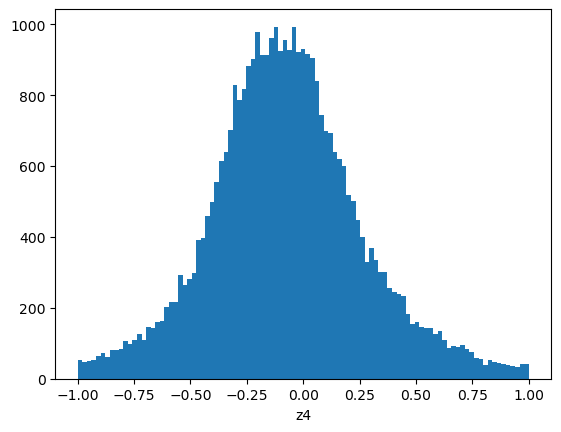

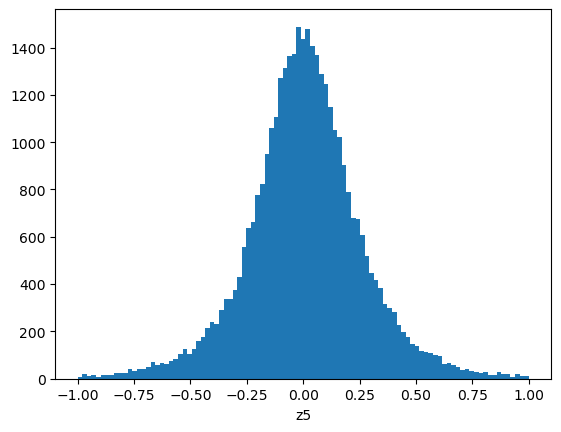

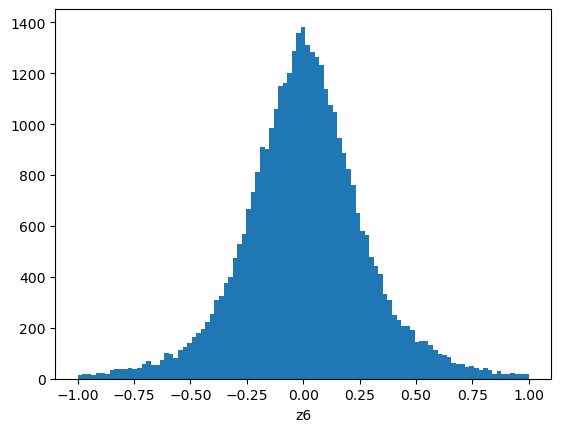

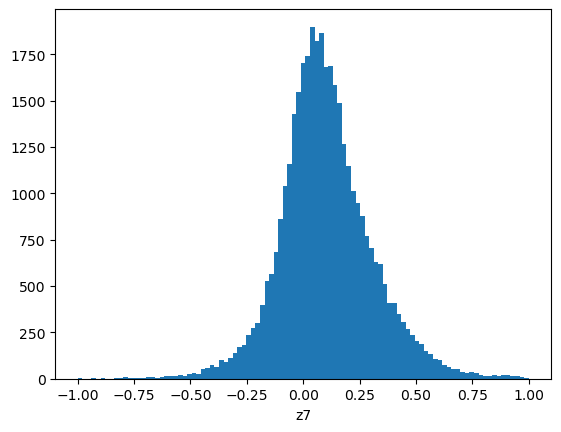

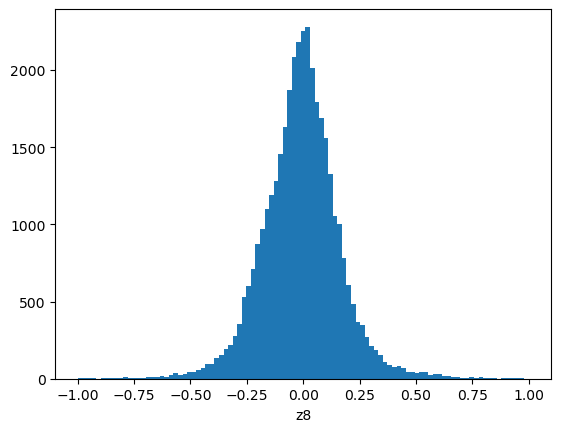

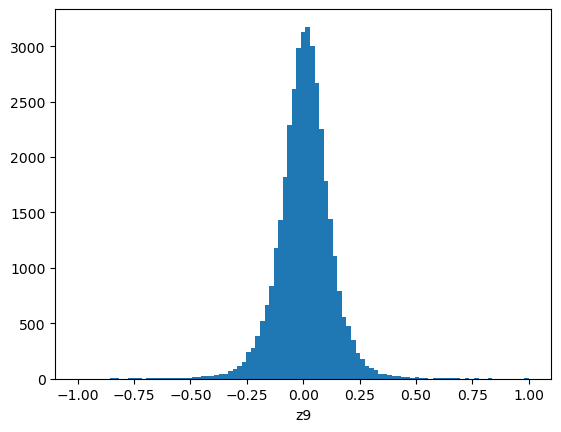

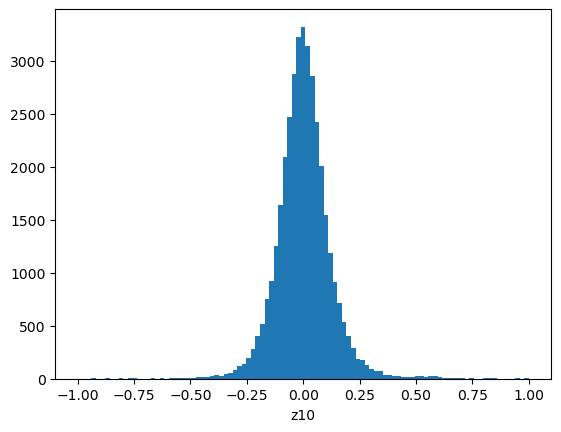

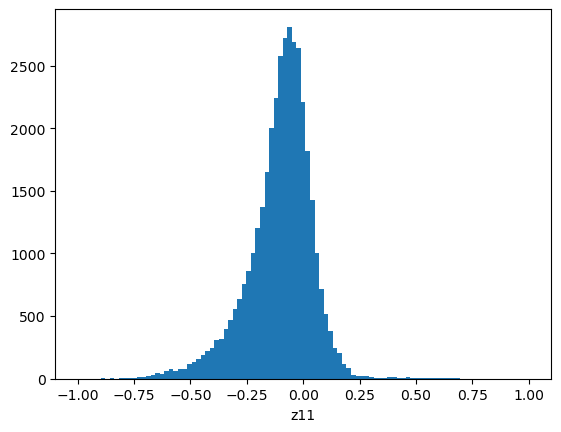

In [3]:

for i in ['4', '5', '6', '7', '8', '9', '10', '11']:
    plt.figure()
    zi = np.array([np.median(dic[visit][f"z{i}"]) for visit in visitIDs])
    _ = plt.hist(zi, bins=np.linspace(-1,1,100))
    plt.xlabel(f"z{i}")